In [26]:
from astropy.io import fits
import numpy as np
from astropy import units 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import os
from tqdm import tqdm
from astropy.table import Table
from astropy.time import Time
from astropy.wcs import WCS
import astropy
from scipy.signal import medfilt
from astropy.stats import sigma_clip
from astropy.timeseries import LombScargle
from matplotlib.colors import LinearSegmentedColormap

parula = np.load('/home/adina/Downloads/parula_colors.npy')
parula_map = LinearSegmentedColormap.from_list('parula', parula)

import warnings
warnings.filterwarnings("ignore")

from astropy.coordinates import SkyCoord

rc = Table.read('rcParams.txt', format='csv')
for name, val in zip(rc['name'], rc['value']):
    plt.rcParams[name] = val

In [3]:
pixels23 = np.load('pixels_2-3_3918PE_xlow-1674_ylow-1341_flipped.npy', allow_pickle=True).item()
data23 = pixels23['pixels'].reshape(pixels23['shape'])
model23 = pixels23['models'].reshape(pixels23['shape'])
time23 = pixels23['time'] + 0.0

locs23 = Table.read('/home/adina/.eleanor/ffis/s0092/locs_2-3_asteroid.csv', format='csv')
#locs23.sort('file')

xshift23 = locs23['x'] - pixels23['extent'][2]
yshift23 = locs23['y'] - pixels23['extent'][0]

In [4]:
size = 9
npixels = size*2+1

tpf23 = np.zeros((len(data23), npixels, npixels))
tpf23_sub = np.zeros((len(data23), npixels, npixels))
good = np.zeros(len(data23))

for i in range(len(data23)):
    inty = int(xshift23[i])
    intx = int(yshift23[i])
    c = data23[i][intx-size:intx+size+1, inty-size:inty+size+1] + 0.0
    mask = sigma_clip(c, sigma=2)
    #if len(np.where(mask.mask==True)[0]) > (11*11)/3:
    #    good[i] = 1

    if len(np.where(mask.mask==True)[0]) > (npixels*npixels)/3.3:
        good[i] = 1
        
    #c[mask.mask] = 0.0
    tpf23[i] = c #/ model23[i][intx-size:intx+size+1, inty-size:inty+size+1]
    tpf23_sub[i] = c / model23[i][intx-size:intx+size+1, inty-size:inty+size+1]

In [5]:
np.save('stacked_A918PE_2-3.npy', {'raw':tpf23,
                               'subtracted':tpf23_sub,
                               'good_frames':good,
                               'time':time23,
                               'loc':[10,10]})

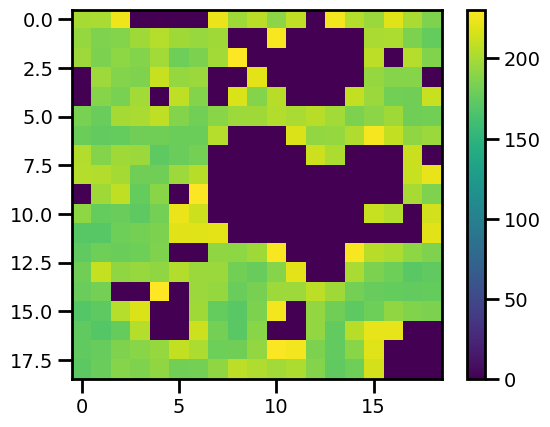

In [6]:
plt.imshow(mask.data*~mask.mask)
plt.colorbar()

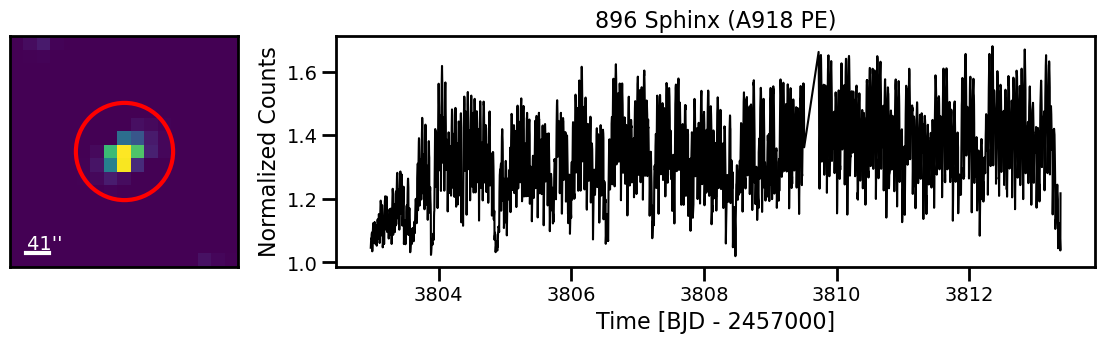

In [90]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14,3),
                                             gridspec_kw={'width_ratios':[0.3,1]})

im = ax1.imshow(np.nansum(tpf23_sub, axis=0)[2:,2:], aspect='auto',
           origin='lower', #cmap='Greys', 
                vmin=4400, vmax=5000)#, vmin=4000, vmax=5000)#parula_map)
#plt.colorbar(im)
ax1.plot(8,8,'ro', ms=70, color="none", markeredgecolor='r', markeredgewidth=3)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_title('896 Sphinx (A918 PE)', fontsize=16)
ax1.axhline(0.5, 0.07, 0.172, color='w', zorder=10, lw=3)
ax1.text(0.8, 0.8, "41''", color='w')

ax1.set_xlim(-0.5, 16.5)
ax1.set_ylim(-0.5, 16.5)


time = (time23+2400000.5)-2457000
ax2.plot(time, tpf23_sub[:,10,10], color='k')

q = time > 3804
freq, power = LombScargle(time*units.day, tpf23_sub[:,10,10]).autopower(minimum_frequency=1.0/(50*units.hour),
                                                                        maximum_frequency=1.0/(5.0*units.hour))


ax2.set_xlabel('Time [BJD - 2457000]', fontsize=16)
ax2.set_ylabel('Normalized Counts', fontsize=16)
plt.subplots_adjust(wspace=0.2)

plt.savefig('asteroid_recovery.pdf', bbox_inches='tight', dpi=300)
#plt.savefig('3I_tess_stacked_cameraccd_23.pdf', bbox_inches='tight', dpi=300)

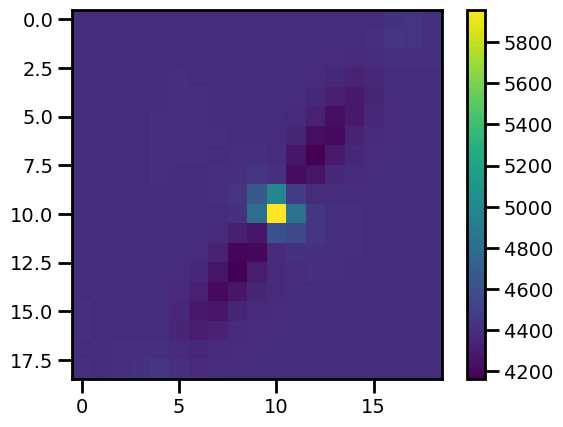

In [36]:
plt.imshow(np.nansum(tpf23_sub, axis=0))
plt.colorbar()

In [52]:
summed_tpf = np.nansum(tpf23[good==1], axis=0)
value = summed_tpf[10,10]

dur = (len(tpf23[good==1])*units.s).value

-2.5*np.log10(value/dur)+20.44

14.040656008684035

In [17]:
def convert_mag(counts):
    dur = (len(counts) * 200 * units.s)
    dur = dur.value
    return -2.5 * np.log10(counts/200) + 20.44

Text(0.5, 0, 'Time [MJD]')

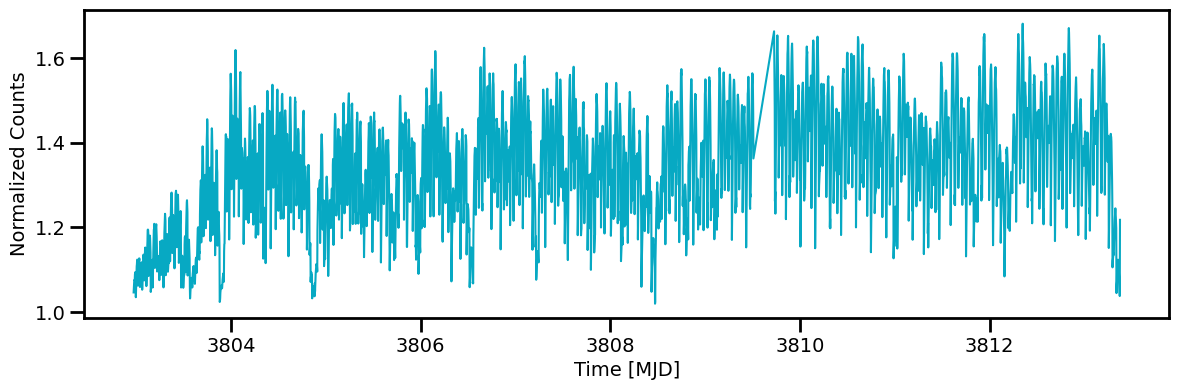

In [18]:
plt.figure(figsize=(14,4))

plt.ylabel('Normalized Counts')
plt.xlabel('Time [MJD]')